In [1]:
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(ggnetwork))
library(magrittr)
suppressPackageStartupMessages(library(tidygraph))
library(tidyverse)
library(cowplot)
library(ggrepel)
library(scatterpie)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

theme_set(theme_cowplot() + theme_transparent)
results <- '../../results/'
fam <- read_delim('~/data/genesis/genesis_2019.fam', delim = ' ', col_names = FALSE, col_types = 'iciiii')
bim <- read_tsv('~/data/genesis/genesis_2019.bim', col_names = FALSE, col_types = 'icidcc')
methods <- c('dmGWAS','heinz','HotNet2','LEAN','SConES GS','SConES GM',
             'SConES GI','SigMod','Consensus','All','Conventional GWAS')
palette_yn <- c('Unselected' = 'gray80', 'Selected' = 'firebrick',
                'No' = 'gray80', 'Yes' = 'firebrick')

method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff6f3c', 'SConES GI' = '#cb181d',
                    'SConES~GI' = '#cb181d',
                    'SigMod' = '#377eb8', 'All' = 'gray50', 
                    'Consensus' = 'black', 'chi^2~+~Bonferroni' = '#000080')
labs <- c('all_snps' = 'All', 'chi^2~+~Bonferroni' = bquote(chi^2 ~ '+ Bonferroni'), 
          'consensus' = 'Consensus', 'dmgwas' = 'dmGWAS', 'heinz' = 'heinz', 
          'hotnet2' = 'HotNet2', 'lean' = 'LEAN', 'SConES~GI' = 'SConES GI', 
          'SConES~GM' = 'SConES GM', 'SConES~GS' = 'SConES GS', 'sigmod' = 'SigMod')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       masks magrittr::extract()
✖ dplyr::filter()        masks tidygraph::filter(), stats::filter()
✖ dplyr::groups()        masks tidygraph::groups(), igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::set_names()     masks magrittr::set_names()
✖ purrr::simplify()      masks igraph::simplify()



# SF1

In [2]:
evs <- read_tsv(paste0(results,'conventional_gwas/genesis_2019.eigenvec'))

options(repr.plot.width=7.4, repr.plot.height=7.5)
pc1_2 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC2, PC1, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc3_4 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC4, PC3, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc5_6 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC6, PC5, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

pc7_8 <- inner_join(evs, fam, by = c('FID' = 'X1', 'IID' = 'X2')) %>%
    mutate(Phenotype = ifelse(X6 == 1, 'Control', 'Case')) %>%
    ggplot(aes(PC8, PC7, color = Phenotype)) +
        geom_point() +
        theme(legend.position = 'none', 
              text = element_text(size = 15)) +
        scale_color_manual(values = c('Case' = '#1b9e77', 'Control' = '#d95f02'))

sf1 <- plot_grid(pc1_2, pc3_4, pc5_6, pc7_8, labels = c('A','B','C','D'))

Parsed with column specification:
cols(
  .default = col_double(),
  IID = col_character()
)

See spec(...) for full column specifications.



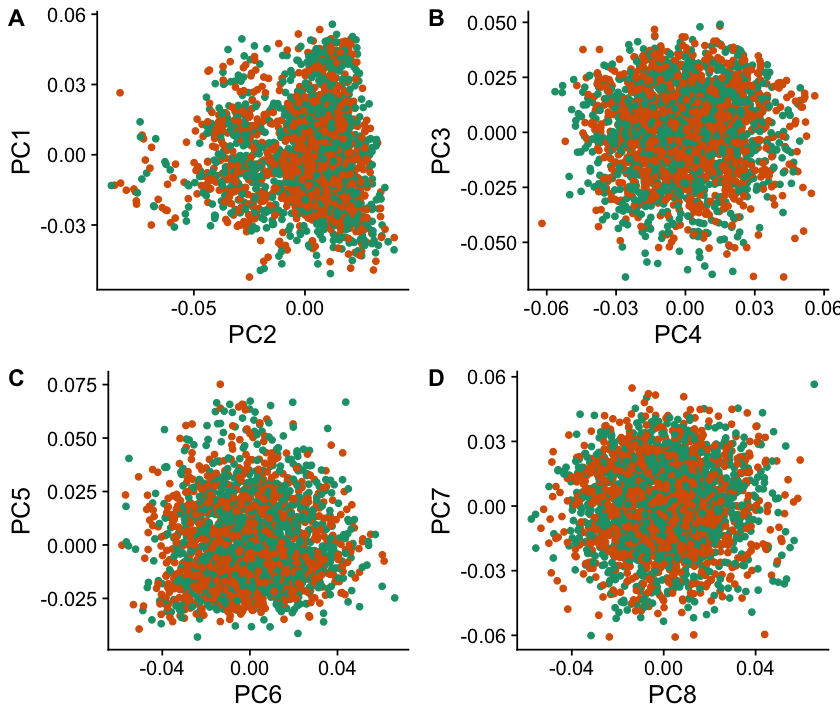

In [3]:
options(repr.plot.width=7, repr.plot.height=6)
sf1
ggsave('figures/sfigure_1.pdf', sf1, width=7, height=6, bg = "transparent")

# SF2: GENESIS Manhattan plot

In [4]:
map <- read_tsv('~/data/genesis/genesis_2019.bim',
                col_names = F, col_types = 'icidcc') %>%
       set_colnames(c('chr', 'snp', 'cm', 'pos', 'x1', 'x2')) %>%
       select(-cm, -x1, -x2)

snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc') %>%
    filter(!grepl('LINC', gene))

gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% 
    group_by(chr) %>% 
    summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>%
    mutate(chr_fix = ifelse(chr %in% c(19,21), '', chr))

options(repr.plot.width=12, repr.plot.height=7.5)
sf2a <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = '#2b2e4a') +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # add gene symbols
    geom_text(data = filter(don, selected == 'Yes' & !is.na(gene)) %>% 
                          group_by(gene) %>% 
                          summarise(P = min(P), BPcum = BPcum[which.min(P)]), 
              aes(x=BPcum, y=-log10(P), label = gene), size = 5, nudge_y = .5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr_fix, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)')) +
    theme_transparent

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [5]:
gwas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                        col_types = 'iciddddddcd') %>%
    mutate(selected = ifelse(`Top-0.1-pvalue` < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(Chr) %>% 
  summarise(chr_len=max(Start)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='Chr') %>%

  # Add a cumulative position of each gene
  arrange(Chr, Start) %>%
  mutate( BPcum=Start+tot)

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$`Top-0.1-pvalue`), na.rm = TRUE) + 1
axisdf <- don %>% 
    group_by(Chr) %>% 
    summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>%
    mutate(chr_fix = ifelse(Chr %in% c(19,21), '', Chr))

options(repr.plot.width=12, repr.plot.height=7.5)
sf2b <- ggplot(don, aes(x=BPcum, y=-log10(`Top-0.1-pvalue`))) +

    # Show all points
    geom_point( aes(color=as.factor(Chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(`Top-0.1-pvalue`)), color = '#2b2e4a') +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # add gene symbols
    geom_text(data = filter(don, selected == 'Yes' & !is.na(Gene)), 
              aes(x=BPcum, y=-log10(`Top-0.1-pvalue`), label = Gene), 
              size = 5, nudge_y = .5) +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr_fix, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)')) +
    theme_transparent

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [6]:
lasso_snps <- read_tsv(paste0(results, 'lasso/scored_snps.lasso.tsv'), col_types = 'cd', comment = '#') %>%
    filter(beta != 0) %>%
    .$snp

gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(snp %in% lasso_snps, 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% 
    group_by(chr) %>% 
    summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>%
    mutate(chr_fix = ifelse(chr %in% c(19,21), '', chr))

options(repr.plot.width=12, repr.plot.height=7.5)
sf2c <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    geom_point(data = filter(don, selected == 'Yes'), aes(x=BPcum, y=-log10(P)), color = '#2b2e4a') +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr_fix, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 15),
      axis.text = element_text(size = 10),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(P-value)')) +
    theme_transparent

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



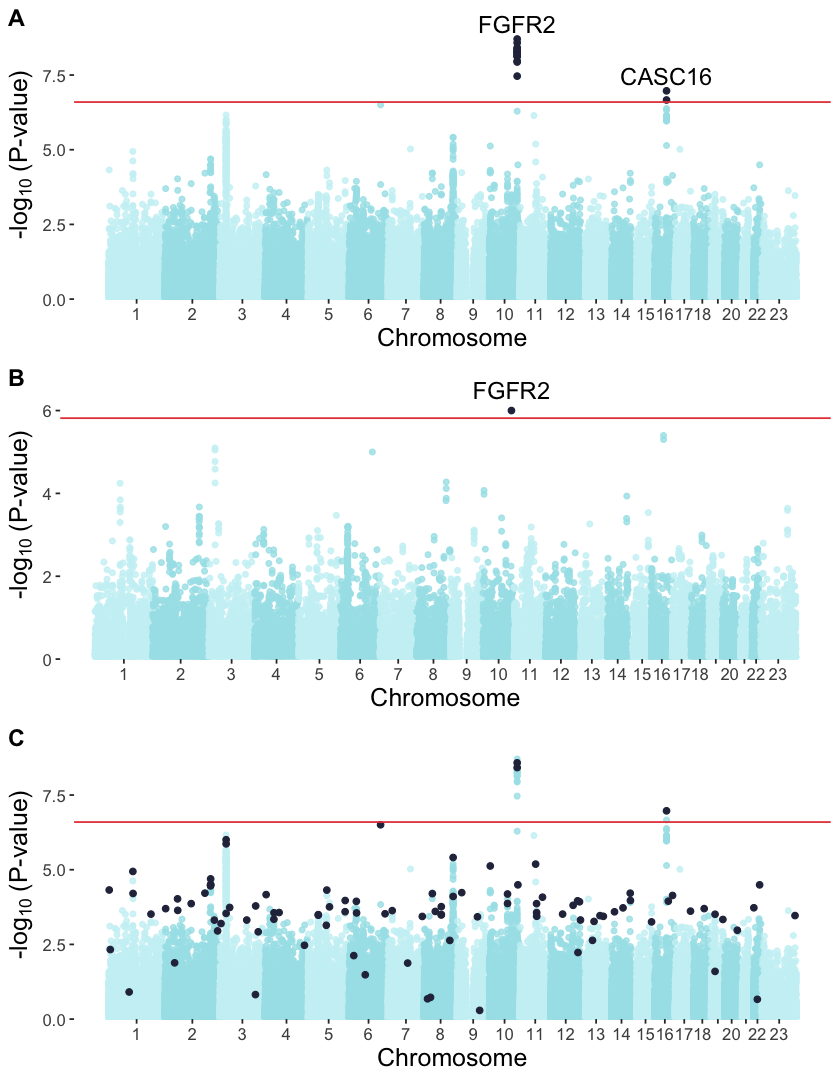

In [7]:
options(repr.plot.width=7, repr.plot.height=9)
sf2 <- plot_grid(sf2a, sf2b, sf2c, labels = c('A', 'B', 'C'), nrow = 3)
sf2
ggsave('figures/sfigure_2.pdf', sf2, width=7, height=9, bg = "transparent")
ggsave('figures/sfigure_2.png', sf2, width=7, height=9, bg = "transparent")

# SF3: consensus network stats

In [8]:
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllllli')
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(betweeness = centrality_betweenness())
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene

# boxplot associated
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene
lean <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
# scones
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')
scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique

num_methods_assoc <- table(c(dmgwas,heinz,hotnet2,lean,sigmod,scones_gi)) %>%
    as.data.frame %>%
    inner_join(vegas, by = c('Var1' = 'Gene')) %>%
    ggplot(aes(x = as.character(Freq), y = -log10(p))) +
        geom_boxplot() +
    scale_color_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = 'gray50')) +
    labs(x = 'Number of methods', y = bquote('-log'[10]~'(P-value)')) +
    theme(legend.position = 'none',
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11))

hist_num_methods <- arrange(consensus, num_methods) %>%
    mutate(gene = factor(gene, levels = gene)) %>%
    ggplot(aes(x = gene, y = num_methods, 
               fill = ifelse(disgenet, 'Yes','No'))) +
        geom_bar(stat = 'identity') +
        coord_flip() +
        scale_fill_manual(values = c('Yes' = '#ff96a7', 'No' = 'gray50')) +
        labs(x = 'Gene', y = 'Number of methods', fill = 'Familial BC gene') +
        theme(legend.position = 'none',
              axis.text = element_text(size = 7),
              axis.title = element_text(size = 11),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 11))

sf3 <- ggplot(consensus, aes(y = -log10(p), x = log10(betweenness))) +
    geom_point(aes(color = ifelse(disgenet, 'Yes','No'))) +
    geom_smooth(method = "glm") +
    labs(x = bquote('log'[10]~'(Betweenness centrality)'), 
         y = bquote('-log'[10]~'(P-value)'), 
         color = 'Familial BC gene') +
    theme(legend.position = 'bottom',
          axis.text = element_text(size = 12),
          axis.title = element_text(size = 15)) +
    scale_color_manual(values = c('Yes' = '#ff96a7', 'No' = 'gray50'))

# legend <- get_legend(hist_num_methods + theme(legend.position = 'bottom',
#                                               legend.justification = 'center'))

# sf5 <- plot_grid(plot_grid(hist_num_methods,
#                            plot_grid(num_methods_assoc, centrality_assoc,
#                                      labels = c('B','C'), nrow = 2),
#                            ncol = 2, labels = 'A'),
#                  legend, nrow = 2, rel_heights = c(10,1))

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”


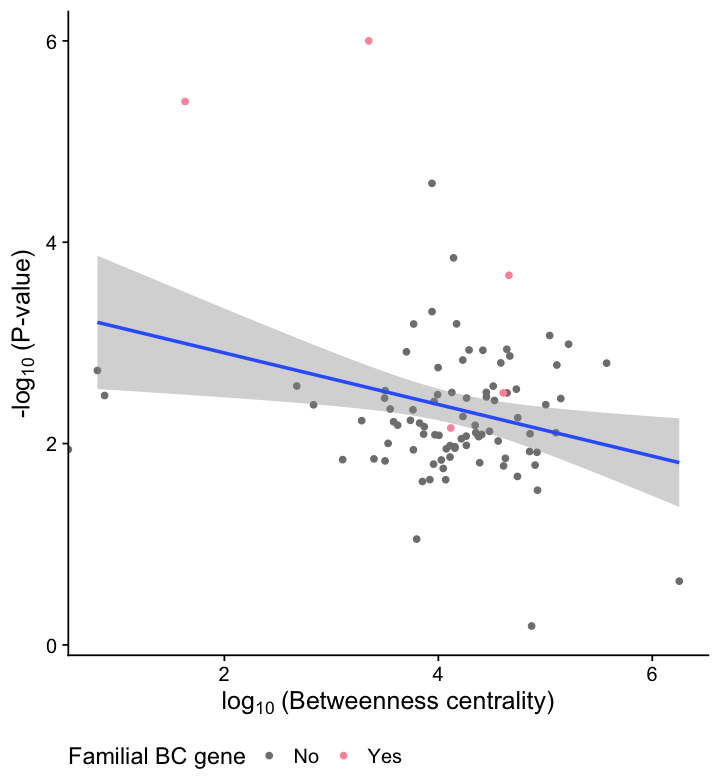

In [9]:
options(repr.plot.width=6, repr.plot.height=6.5)
sf3
ggsave('figures/sfigure_3.pdf', sf3, width=6, height=6.5, bg = "transparent")

# SF4: additional benchmarks

In [10]:
##########################
#     BIOMARKER PANEL    # 
##########################

get_precision_recall <- function(genes, selected, method, bonf) {
    
    genes %>%
        mutate(sign = P < bonf,
               selected = marker %in% selected) %>%
        summarize(precision = sum(selected & sign)/sum(selected),
                  recall = sum(selected & sign)/sum(sign)) %>%
        mutate(method = method)
    
}

vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)

ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    left_join(vegas, by = c('name' = 'Gene'))

# use only genes and SNPs that can be found in the PPIN & in GENESIS
genes_in_ppi <- names(V(ppi))
genes_in_genesis <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd') %>%
    .$Gene
snps_in_genesis <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd') %>%
    .$SNP

# GENESIS
##########################
genesis_sign <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd')  %>%
    filter(P < (.05/n()) ) %>%
    .$SNP
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllllli')$gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc', 
         comment = '#', col_names = F) %>%
    select(X1) %>%
    separate_rows(X1, sep = ' ') %>%
    .$X1
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp

# BCAC
##########################
genes <- read_tsv(paste0(results,'bcac/scored_genes.vegas.join_genesis.txt'), 
                  col_types = 'iciddddddcddddddcdll') %>%
    filter(Gene %in% genes_in_ppi) %>%
    rename(P = `Top-0.1-pvalue_bcac`,
           marker = Gene) %>%
    select(marker, P)

snps <- read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), 
                 col_types = 'icdcddcddd') %>%
    filter(SNP %in% snps_in_genesis) %>%
    rename(marker = SNP) %>%
    select(marker, P)

bcac_comparison <- bind_rows(get_precision_recall(snps, genesis_sign, 'chi^2~+~Bonferroni', .05 / nrow(snps)),
                             get_precision_recall(genes, consensus, 'Consensus', .05 / nrow(genes)),
                             get_precision_recall(genes, heinz, 'heinz', .05 / nrow(genes)),
                             get_precision_recall(genes, sigmod, 'SigMod', .05 / nrow(genes)),
                             get_precision_recall(genes, dmgwas, 'dmGWAS', .05 / nrow(genes)),
                             get_precision_recall(genes, hotnet2, 'HotNet2', .05 / nrow(genes)),
                             get_precision_recall(snps, gi, 'SConES~GI', .05 / nrow(snps))) %>%
    ggplot(aes(recall, precision, color = method, label = method)) +
        geom_abline(slope = 1, color = 'gray80') +
        geom_point() +
        geom_text_repel(parse = T) +
        labs(x = 'Recall', y = 'Precision') + 
        scale_x_continuous(labels = scales::percent) +
        scale_y_continuous(labels = scales::percent, breaks = c(0, 0.5, 1)) +
        scale_color_manual(values = method_palette, labels = labs) +
        theme(legend.position = 'none',
              text = element_text(size = 10),
              axis.title = element_text(size = 15))

In [11]:
methods <- c('dmGWAS','heinz','HotNet2','LEAN','SigMod','All SNPs',
             'SConES~GS','SConES~GM','SConES~GI','Consensus',
             'chi^2~+~Bonferroni')
labs <- c('all_snps' = 'All SNPs', 'chi^2~+~Bonferroni' = bquote(chi^2 ~ '+ Bonferroni'), 
          'consensus' = 'Consensus', 'dmgwas' = 'dmGWAS', 'heinz' = 'heinz', 
          'hotnet2' = 'HotNet2', 'lean' = 'LEAN', 'SConES~GI' = 'SConES GI', 
          'SConES~GM' = 'SConES GM', 'SConES~GS' = 'SConES GS', 'sigmod' = 'SigMod')

pred_ht <- read_tsv(paste0(results,'benchmark/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones_gs', 'SConES~GS', method),
           method = ifelse(method == 'scones_gm', 'SConES~GM', method),
           method = ifelse(method == 'scones_gi', 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'all_snps', 'All SNPs', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           method = factor(method, levels = rev(methods)))

naive_classifier <- max(table(fam$X6) / nrow(fam))

sens_spec <- pred_ht %>%
    filter(! method %in% c('SConES~GS', 'SConES~GM')) %>%
    group_by(method) %>%
    summarize(se_sensitivity = sd(sensitivity) / sqrt(n()),
              se_specificity = sd(specificity) / sqrt(n()),
              sensitivity = mean(sensitivity),
              specificity = mean(specificity)) %>%
    ggplot(aes(x = sensitivity, y = specificity, label = method, color = method)) +
        geom_hline(yintercept = naive_classifier, color = 'gray50', linetype="dashed") +
        geom_vline(xintercept = naive_classifier, color = 'gray50', linetype="dashed") +
        geom_errorbar(aes(ymin = specificity - se_specificity, 
                          ymax = specificity + se_specificity), width = .0025) +
        geom_errorbarh(aes(xmax = sensitivity + se_sensitivity, 
                           xmin = sensitivity - se_sensitivity), height = .0025) +
        geom_point() +
        scale_fill_manual(values = method_palette, labels = labs) +
        scale_color_manual(values = method_palette, labels = labs) +
        labs(x = 'Sensitivity', y = 'Specificity', color = 'Method') +
        theme(legend.position = 'bottom',
              legend.justification="center",
              text = element_text(size = 10),
              axis.title = element_text(size = 15),
              legend.text = element_text(size = 12),
              legend.title = element_text(size = 15)) + 
        guides(fill = "none")

legend <- get_legend(sens_spec)

`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


Warning message:
“Removed 1 rows containing missing values (geom_point).”


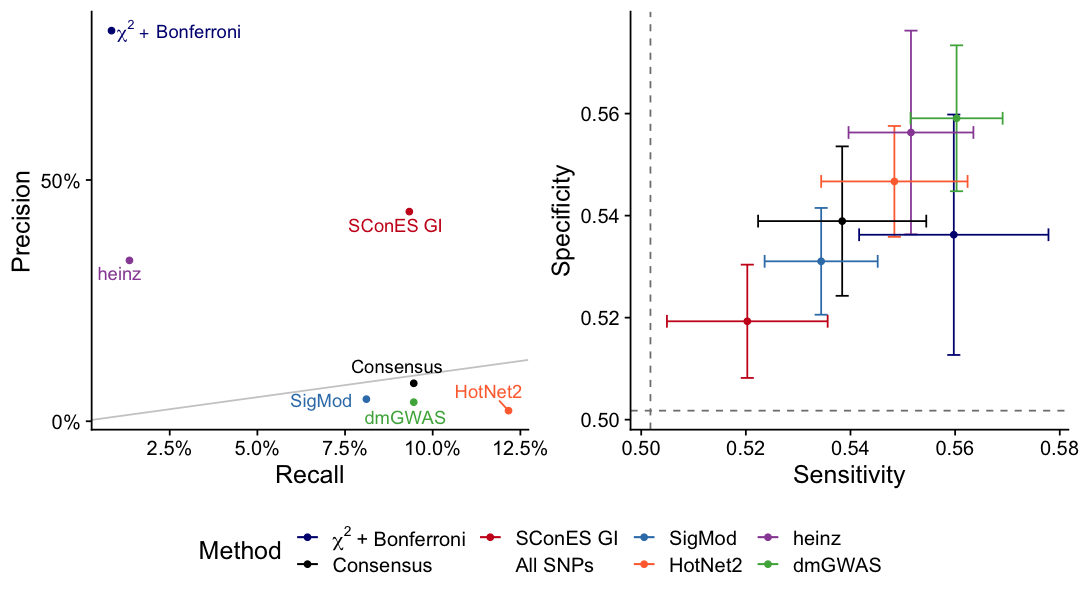

In [12]:
sf4 <- plot_grid(plot_grid(bcac_comparison, sens_spec + theme(legend.position = 'none')),
          legend,
          nrow = 2, rel_heights = c(1, .2))

options(repr.plot.width=9, repr.plot.height=5)
sf4
ggsave('figures/sfigure_4.pdf', sf4, width=9, height=5, bg = "transparent")

# SF5: Heterogeneity (all methods, genes and SNPs)

In [13]:
methods <- c('dmGWAS','heinz','HotNet2','LEAN','SConES GS','SConES GM','SConES GI','SigMod')

vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd')
all_genes <- unique(vegas$Gene)

dmgwas <- all_genes %in% (read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene)
heinz <- all_genes %in% (read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene)
hotnet2 <- all_genes %in% (read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene)
lean <- all_genes %in% (read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene)
sigmod <- all_genes %in% (read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene)
# scones
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')
scones_gs <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)
scones_gm <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)
scones_gi <- all_genes %in% (read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique)

bms <- list(dmgwas, heinz, hotnet2, lean, scones_gs, scones_gm, scones_gi, sigmod)
pearson_gene <- lapply(bms, function(x) 
            lapply(bms, cor, x) ) %>%
    do.call(cbind, .) %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, corr, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           corr = round(as.numeric(corr), digits = 3)) %>%
    ggplot(aes(x = method1, y = method2, fill = corr, label = corr)) +
        geom_tile() +
        geom_text() +
        theme_bw() +
        scale_fill_gradient(low = 'white', high = '#de2d26') +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(angle = 45, vjust = 0.5)) +
        theme_transparent

all_snps <- bim$X2

dmgwas <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene])
heinz <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene])
hotnet2 <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc')$gene])
lean <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% (read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>% .$Gene)])
sigmod <- all_snps %in% (snp2gene$snp[snp2gene$gene %in% read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene])
scones_gs <- all_snps %in% (read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp %>%
    unique)
scones_gm <- all_snps %in% (read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp %>%
    unique)
scones_gi <- all_snps %in% (read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp %>%
    unique)

bms <- list(dmgwas, heinz, hotnet2, lean, scones_gs, scones_gm, scones_gi, sigmod)
pearson_snp <- lapply(bms, function(x) 
            lapply(bms, cor, x) ) %>%
    do.call(cbind, .) %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, corr, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           corr = round(as.numeric(corr), digits = 3)) %>%
    ggplot(aes(x = method1, y = method2, fill = corr, label = corr)) +
        geom_tile() +
        geom_text() +
        theme_bw() +
        scale_fill_gradient(low = 'white', high = '#de2d26') +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(angle = 45, vjust = 0.5)) +
        theme_transparent
                   
sf5 <- plot_grid(pearson_gene, pearson_snp, labels = c('A','B'))

Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in FUN(X[[i]], ...):
“the standard deviation is zero”
Warning message in F

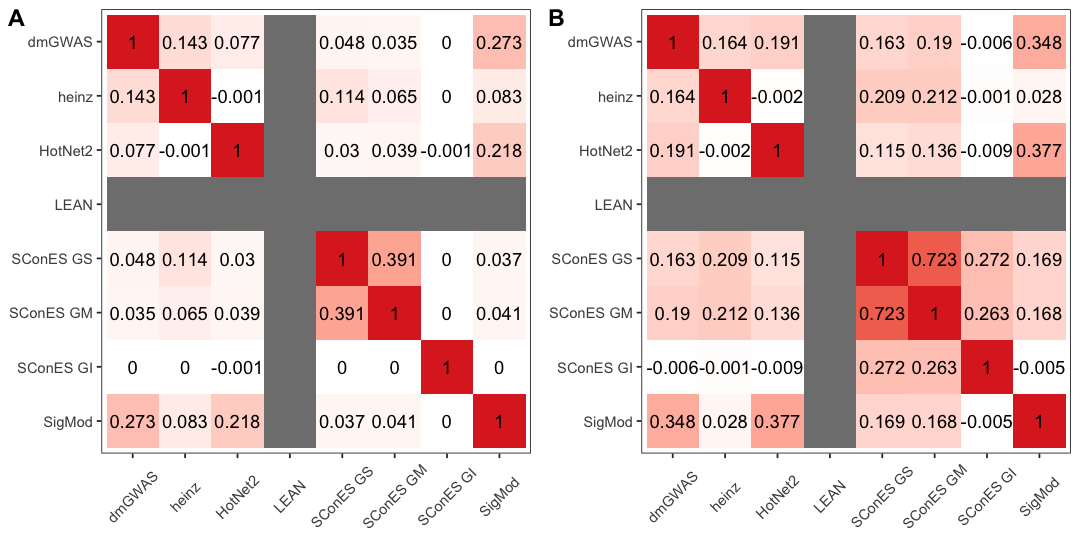

In [14]:
options(repr.plot.width=9, repr.plot.height=4.5)
sf5
ggsave('figures/sfigure_5.pdf', sf5, width=9, height=4.5, bg = "transparent")

# SF6 Rewirings

In [15]:
# compute network metrics
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(degree = centrality_degree()) %>%
    left_join(vegas, by = c('name' = 'Gene'))
ppi_df <- as_tibble(ppi)

gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd')

load(paste0(results,'scones/gi_network.RData'))
gi <- net %>%
    as_tbl_graph %>%
    mutate(degree = centrality_degree()) %>%
    left_join(gwas, by = c('name' = 'SNP')) %>%
    rename(p = P)
gi_df <- as_tibble(gi)

read_heinz <- function() {
    lapply(list.files(paste0(results,'rewiring/heinz'), full.names = T, pattern = 'heinz_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(i = gsub('.*heinz_', '', f)  %>% gsub('.txt', '', .),
                   method = 'heinz')
        }) %>%
        bind_rows
}

read_dmgwas <- function() {
    
    lapply(list.files(paste0(results,'rewiring/dmgwas'), full.names = T, pattern = 'dmgwas_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(i = gsub('.*dmgwas_', '', f)  %>% gsub('.txt', '', .),
                   method = 'dmGWAS')
        }) %>%
        bind_rows
    
}

read_lean <- function() {
    
    lapply(list.files(paste0(results,'rewiring/lean'), full.names = T, pattern = 'lean_*'), function(f) {
        read_tsv(f, col_types = 'cddiidddd') %>%
            filter(PLEAN < 0.05) %>%
            rename(gene = Gene) %>%
            select(gene) %>%
            mutate(i = gsub('.*lean_', '', f)  %>% gsub('.txt', '', .),
                   method = 'LEAN')
    }) %>%
        bind_rows

}

read_sigmod <- function() {
    
    lapply(list.files(paste0(results,'rewiring/sigmod'), full.names = T, pattern = 'sigmod_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(i = gsub('.*sigmod_', '', f)  %>% gsub('.txt', '', .),
                   method = 'SigMod')
        }) %>%
        bind_rows
    
}

read_scones <- function() {
    lapply(list.files(paste0(results,'rewiring/scones'), full.names = T, pattern = 'cones_*'), function(f) {
        read_tsv(f, col_types = 'ciidccdli') %>%
            filter(selected) %>%
            select(snp, c) %>%
            mutate(i = gsub('.*cones_', '', f)  %>% gsub('.tsv', '', .),
                   method = 'SConES GI', type = 'SNP')
        }) %>%
        bind_rows %>%
        inner_join(gi_df, by = c('snp' = 'name')) %>%
        mutate(gene = snp,
               run = 'Rewired') %>%
        select(method, type, run, i, gene, degree, p)
}

true_run <- bind_rows(bind_rows(read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c') %>%
                                    mutate(method = 'heinz', run = 'Original', i = NA) %>%
                                    inner_join(ppi_df, by = c('gene' = 'name')) %>%
                                    select(method, run, i, gene, degree, p),
                                read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c') %>%
                                    mutate(method = 'dmGWAS', run = 'Original', i = NA) %>%
                                    inner_join(ppi_df, by = c('gene' = 'name')) %>%
                                    select(method, run, i, gene, degree, p),
                                read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
                                    filter(PLEAN < 0.05) %>%
                                    rename(gene = Gene) %>%
                                    mutate(method = 'LEAN', run = 'Original', i = NA) %>%
                                    inner_join(ppi_df, by = c('gene' = 'name')) %>%
                                    select(method, run, i, gene, degree, p),
                                read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c') %>%
                                    mutate(method = 'SigMod', run = 'Original', i = NA) %>%
                                    inner_join(ppi_df, by = c('gene' = 'name')) %>%
                                    select(method, run, i, gene, degree, p)) %>%
                          mutate(type = 'Gene') %>%
                          select(method, type, run, i, gene, degree, p),
                      read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'ciidccdli') %>%
                          filter(selected) %>%
                          select(snp, c) %>%
                          inner_join(gi_df, by = c('snp' = 'name')) %>%
                          mutate(method = 'SConES GI', run = 'Original', i = NA, type = 'SNP',
                                 gene = snp) %>%
                          select(method, type, run, i, gene, degree, p))

sf6 <- bind_rows(read_dmgwas(),
                  read_heinz(),
                  read_lean(),
                  read_sigmod()) %>%
    mutate(run = 'Rewired', type = 'Gene') %>%
    inner_join(ppi_df, by = c('gene' = 'name'))  %>%
    select(method, type, run, i, gene, degree, p) %>%
    bind_rows(true_run,
              read_scones()) %>%
    filter(run == 'Rewired') %>%
    group_by(gene, method) %>%
    summarize(n = n(), degree = median(degree), p = median(p)) %>%
    ggplot(aes(x = n, y = degree)) +
        geom_point(aes(color = method)) +
        geom_smooth(method = "glm", color = 'gray50') +
        ggpubr::stat_cor(color = 'black') +
        scale_y_log10() +
        labs(x = 'Number of times selected', y = 'Node degree') +
        facet_wrap(method ~ ., scales = 'free') +
        scale_color_manual(values = method_palette) +
        theme(legend.position = 'none')

`summarise()` regrouping output by 'gene' (override with `.groups` argument)



`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



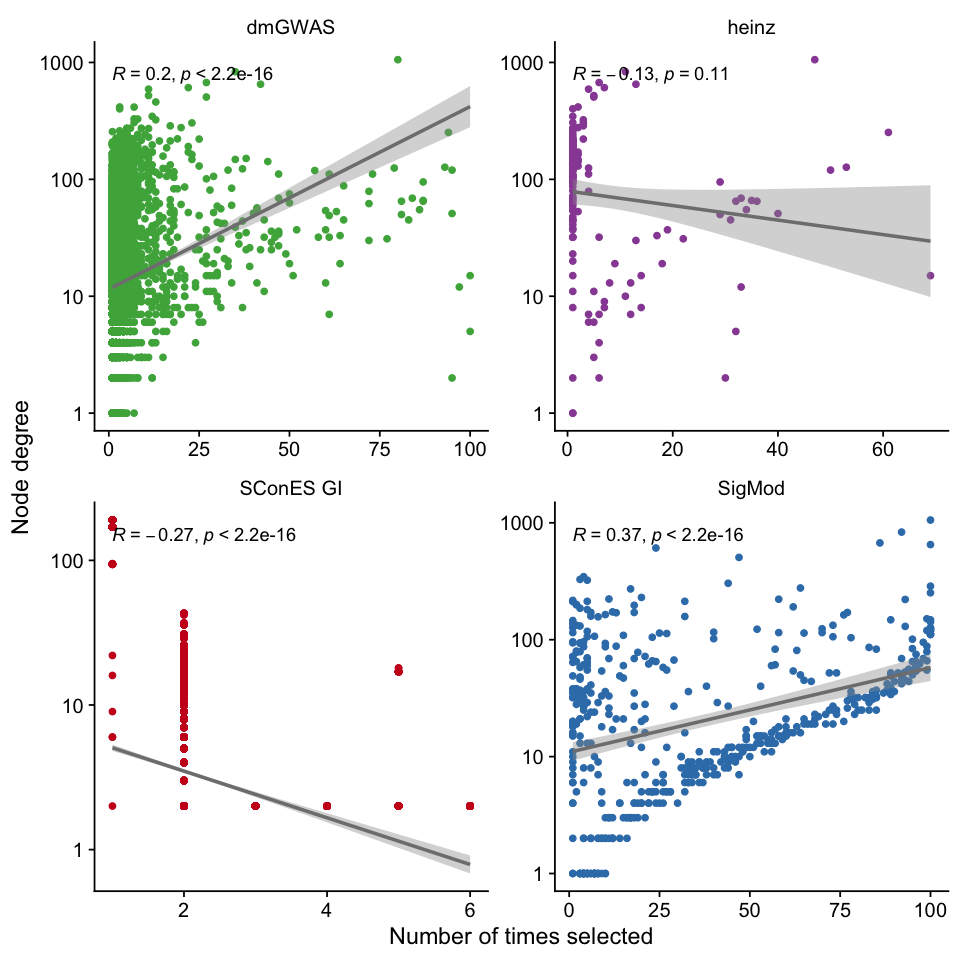

In [16]:
options(repr.plot.width=8, repr.plot.height=8)
sf6
ggsave('figures/sfigure_6.pdf', sf6, width=8, height=8, bg = "transparent")

# SF7 Parameter space

In [17]:
# load bcac results
bcac <- read_tsv(paste0(results,'bcac/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>%
    # remove genes not in the PPI
    filter(Gene %in% ppi$`Official Symbol Interactor A` | Gene %in% ppi$`Official Symbol Interactor B`)
bcac_snps <- read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), col_types = 'icdcddcddd') %>%
    mutate(padj = p.adjust(P, method = 'bonferroni'))

## genes
P_genes <- filter(bcac, `Top-0.1-pvalue` < 0.05 / n())$Gene
N_genes <- filter(bcac, `Top-0.1-pvalue` >= 0.05 / n())$Gene

## snps
P_snps <- filter(bcac_snps, padj  < 0.05 / n())$SNP
N_snps <- filter(bcac_snps, padj >= 0.05 / n())$SNP

read_vegas <- function() {
    chi2 <- read_tsv(paste0(results, 'preprocessing/scored_genes.vegas.txt'), col_types = 'iciddddddcd') %>%
        filter(Gene %in% bcac$Gene)
    thresholds <- c(1e-6, 1e-4, 1e-2, seq(0, 1, 0.05))
    
    lapply(thresholds, function(cutoff) {
        filter(chi2, `Top-0.1-pvalue` < cutoff) %>%
            add_row(Gene = NA) %>%
            mutate(method = 'vegas',
                   tp = Gene %in% P_genes,
                   params = as.character(cutoff)) %>%
        select(Gene, method, params, tp)
    }) %>%
    bind_rows
}

read_dmgwas <- function() {
    
    lapply(list.files(paste0(results,'params/dmgwas'), full.names = T, pattern = 'dmgwas_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            add_row(gene = NA) %>%
            mutate(params = gsub('.*dmgwas_', '', f)  %>% gsub('.txt', '', .),
                   d = gsub('d_', '', params) %>% gsub('_r_.*', '', .) %>% as.numeric,
                   r = gsub('d_[1-3]_r_', '', params) %>% as.numeric, 
                   method = 'dmGWAS',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
    
}

read_heinz <- function() {
    lapply(list.files(paste0(results,'params/heinz'), full.names = T, pattern = 'heinz_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            add_row(gene = NA) %>%
            mutate(params = gsub('.*heinz_', '', f)  %>% gsub('.txt', '', .),
                   method = 'heinz',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
}

read_hotnet <- function() {
    lapply(list.files(paste0(results,'params/hotnet2'), full.names = T, pattern = 'hotnet2_*'), function(f) {
        read_tsv(f, col_types = 'ci') %>%
            select(gene) %>%
            add_row(gene = NA) %>%
            mutate(params = gsub('.*hotnet2_', '', f)  %>% gsub('.tsv', '', .),
                   method = 'HotNet2',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
}

read_lean <- function() {
    lean <- read_tsv(paste0(results, 'lean/scored_genes.lean.txt'), col_types = 'cddiidddd')

    lapply(seq(0, 1, 0.05), function(cutoff) {
        filter(lean, PLEAN < cutoff) %>%
            add_row(Gene = NA) %>%
            mutate(method = 'LEAN',
                   tp = Gene %in% P_genes,
                   params = as.character(cutoff)) %>%
        select(Gene, method, params, tp)
    }) %>%
        bind_rows
}

read_sigmod <- function() {
    
    lapply(list.files(paste0(results,'params/sigmod'), full.names = T, pattern = 'sigmod_*'), function(f) {
        read_tsv(f, col_types = 'c') %>%
            mutate(params = gsub('.*sigmod_', '', f)  %>% gsub('.txt', '', .),
                   lambdamax = gsub('lambdamax_', '', params) %>% gsub('_nmax_.*', '', .) %>% as.numeric,
                   nmax = gsub('lambdamax_1_nmax_', '', params) %>% gsub('_maxjump_.*', '', .)  %>% as.numeric, 
                   maxjump = gsub('lambdamax_1_nmax_[0-9]+_maxjump_', '', params) %>% as.numeric, 
                   method = 'SigMod',
                   tp = gene %in% P_genes)
        }) %>%
        bind_rows
    
}

read_scones <- function(run) {
    lapply(list.files(paste0(results,'params/scones/run_', run), full.names = T, pattern = 'cones_*'), function(f) {
        read_tsv(f, col_types = 'ciidccdli') %>%
            select(snp, selected) %>%
            mutate(params = gsub('.*cones_', '', f)  %>% gsub('.tsv', '', .),
                   eta    = gsub('eta_', '', params) %>% gsub('_lambda_.*', '', .) %>% as.numeric,
                   lambda = gsub('eta_.*_lambda_', '', params) %>% as.numeric,
                   method = 'SConES GI',
                   tp = ifelse(selected, snp %in% P_snps, FALSE))
        }) %>%
        bind_rows %>%
        inner_join(gi_df, by = c('snp' = 'name')) %>%
        group_by(method, params, eta, lambda) %>%
        summarize(tpr  = sum(tp) / length(P_snps),
                  fpr  = (sum(selected) - sum(tp)) / length(N_snps),
                  n    = sum(selected),
                  degree = median(degree),
                  type = 'SNP') %>%
        ungroup
}
           
read_chi2 <- function() {
    chi2 <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), col_types = 'icdccccddd')
    thresholds <- c(1e-6, 1e-4, 1e-2, seq(0, 1, 0.05))
    
    lapply(thresholds, function(cutoff) {
        filter(chi2, P < cutoff) %>%
            add_row(SNP = NA) %>%
            rename(snp = SNP) %>%
            mutate(method = 'chi2',
                   tp = snp %in% P_snps,
                   params = as.character(cutoff)) %>%
        select(snp, method, params, tp)
    }) %>%
    bind_rows %>%
    group_by(method, params) %>%
    summarize(tpr = sum(tp) / length(P_snps),
              fpr = (n() - sum(tp)) / length(N_snps),
              n   = n(),
              type = 'SNP')
}

vegas_pars <- read_vegas()
dmgwas_pars <- read_dmgwas()
heinz_pars <- read_heinz()
hotnet_pars <- read_hotnet()
lean_pars <- read_lean()
sigmod_pars <- read_sigmod()
scones_pars <- read_scones(1)
chi2_pars <- read_chi2()

stats <- bind_rows(vegas_pars,
                   dmgwas_pars %>% select(-d, -r),
                   heinz_pars,
                   hotnet_pars,
                   lean_pars,
                   sigmod_pars %>% select(-lambdamax, -nmax, -maxjump)
                  ) %>%
    group_by(method, params) %>%
    summarize(fpr = (n() - sum(tp)) / length(N_genes),
              tpr = sum(tp) / length(P_genes),
              n   = n(),
              type = 'Gene') %>%
    bind_rows(scones_pars %>% select(-eta, -lambda, -degree),
              chi2_pars) %>%
    ungroup %>%
    add_row(method = 'vegas', params = NA, tpr = 1, fpr = 1, type = 'Gene') %>%
    add_row(method = 'dmGWAS', params = NA, tpr = 1, fpr = 1, type = 'Gene') %>%
    add_row(method = 'heinz', params = NA, tpr = 1, fpr = 1, type = 'Gene') %>%
    add_row(method = 'HotNet2', params = NA, tpr = 1, fpr = 1, type = 'Gene') %>%
    add_row(method = 'LEAN', params = NA, tpr = 1, fpr = 1, type = 'Gene') %>%
    add_row(method = 'SigMod', params = NA, tpr = 1, fpr = 1, type = 'Gene') %>%
    add_row(method = 'chi2', params = NA, tpr = 1, fpr = 1, type = 'SNP') %>%
    add_row(method = 'SConES GI', params = NA, tpr = 1, fpr = 1, type = 'SNP')

`summarise()` regrouping output by 'method', 'params', 'eta' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)



In [18]:
##########################
#      SOLUTION SIZE     # 
##########################
plot_sizes <- function(x) {
    
    x %>%
        filter(! method %in% c('chi2', 'vegas')) %>%
        filter(! is.na(params)) %>%
        ggplot(aes(x = method, y = n)) +
            geom_boxplot() +
            labs(y = 'Solution size') +
            facet_wrap(type ~ ., scales = 'free') +
            theme(axis.title.x = element_blank(),
                  legend.position = 'none',
                  axis.text.y = element_text(size = 14),
                  axis.text.x = element_text(size = 14),
                  axis.title.y = element_text(size = 15),
                  strip.text = element_text(size = 15),
                  strip.background = element_rect(fill="gray90"))
    
}

size_plt <- plot_grid(filter(stats, type == 'Gene') %>% plot_sizes, 
          filter(stats, type != 'Gene') %>% plot_sizes +
              theme(axis.title.y = element_blank()), 
          rel_widths = c(3,1))

size_plt_perc <- bind_rows(pivot_longer(dmgwas_pars, d, names_to = 'par'),
                           pivot_longer(dmgwas_pars, r, names_to = 'par'),
                           mutate(hotnet_pars, par = 'cutoff', value = as.numeric(params)),
                           mutate(heinz_pars, par = 'cutoff', value = as.numeric(params)),
                           mutate(lean_pars, par = 'cutoff', value = as.numeric(params)),
                           pivot_longer(sigmod_pars, nmax, names_to = 'par'),
                           pivot_longer(sigmod_pars, maxjump, names_to = 'par')) %>%
    group_by(method, params, par, value) %>%
    summarize(n = n()) %>%
    ungroup %>%
    bind_rows(pivot_longer(scones_pars, lambda, names_to = 'par') %>% 
                  select(method, params, par, value, n),
              pivot_longer(scones_pars, eta, names_to = 'par') %>% 
                  select(method, params, par, value, n)) %>%
    group_by(method, par, value) %>%
    summarize(n = median(n)) %>%
    group_by(method) %>%
    mutate(n = (n - min(n)) / (max(n) - min(n)),
           n = ifelse(is.na(n), 0, n),
           method_par = paste0(method, "'s ", par)) %>%
    group_by(method, par) %>%
    mutate(value = (value - min(value)) / (max(value) - min(value))) %>%
    ggplot(aes(x = value, y = n, color = method_par)) +
        geom_line(aes(x = value), size = 1.5) +
        scale_x_continuous(labels = scales::percent) +
        scale_y_continuous(labels = scales::percent) +
        labs(x = 'Parameter value (% max tested)', 
             y = 'Solution size (% max observed)',
             color = 'Parameter') +
        guides(color = guide_legend(nrow = 4, byrow=TRUE)) +
        theme(legend.position = 'top')

###########################
#    SConES PARAMETERS    # 
###########################
scones_pars_plt <- ungroup(scones_pars) %>%
    mutate(eta = factor(format(eta, digits = 1), 
                        levels = format(sort(unique(eta)), digits = 1)),
           lambda = factor(format(lambda, digits = 1), 
                           levels = format(sort(unique(lambda)), digits = 1))) %>%
    ggplot(aes(x = eta, y = lambda, fill = n)) +
        geom_tile() +
        scale_fill_gradient(low = '#fff5f0', high = '#a50f15', 
                             breaks = c(0, 1e5, 1.9e5),
                             labels = c(0, expression(10^5), expression(2 %*% 10^5))) +
        labs(x = expression(eta), y = expression(lambda), fill = 'Number of selected SNPs') +
        theme(legend.position = 'top',
              axis.title = element_text(size = 15),
              axis.text.x = element_text(size = 14, angle = 45, vjust = .5),
              axis.text.y = element_text(size = 14))

sf7 <- plot_grid(size_plt_perc, size_plt,
                 labels = c('A','B'), label_size = 25)

`summarise()` regrouping output by 'method', 'params', 'par' (override with `.groups` argument)

`summarise()` regrouping output by 'method', 'par' (override with `.groups` argument)



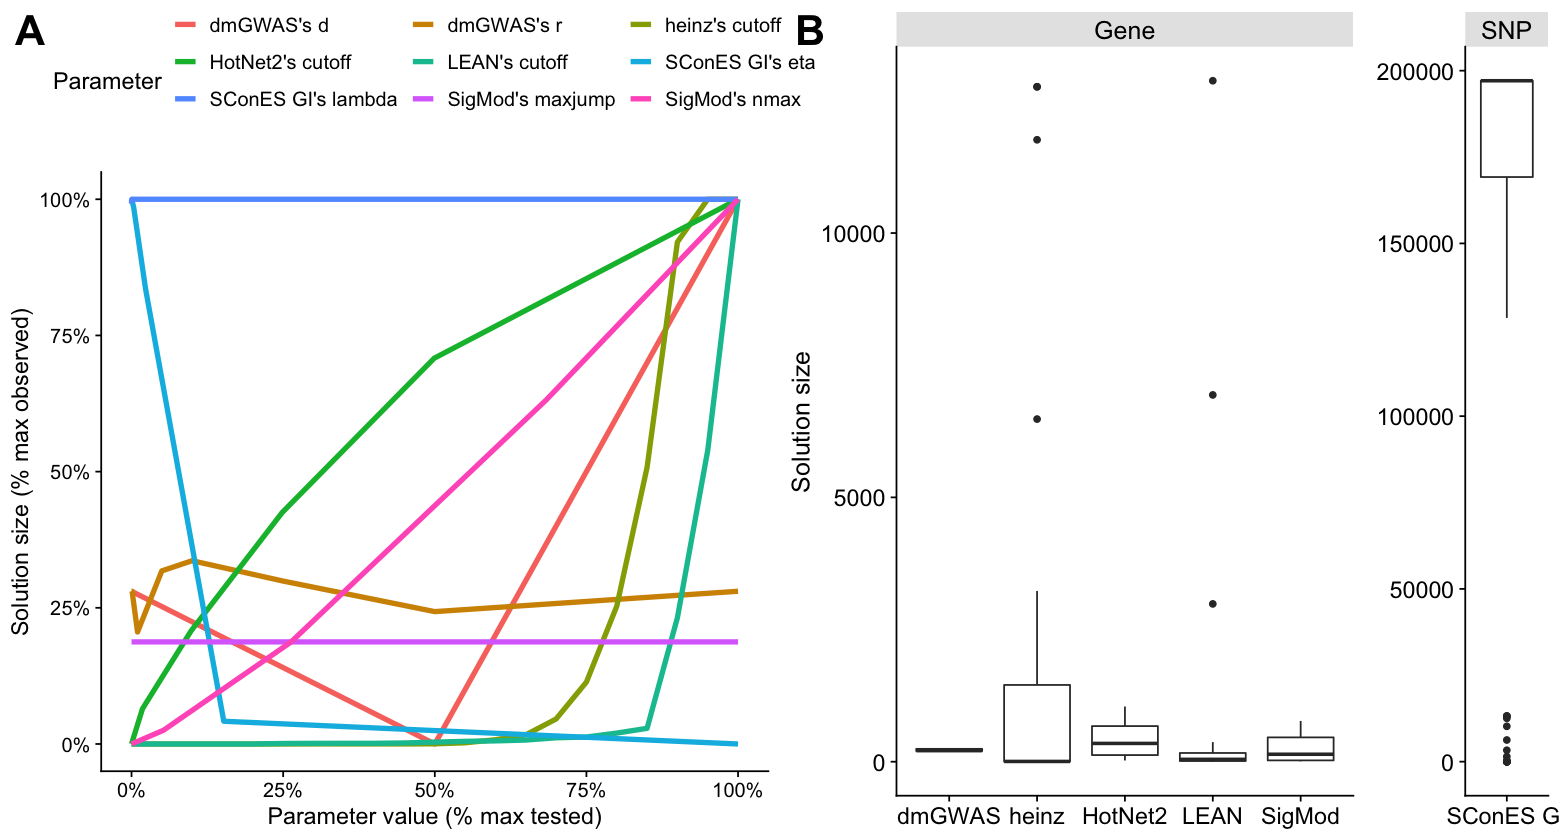

In [19]:
options(repr.plot.width=13, repr.plot.height=7)
sf7
ggsave('figures/sfigure_7.pdf', sf7, width=13, height=7, bg = "transparent")

# SF8: Pearsons params

In [37]:
###########################
#   PEARSON CORRELATION   # 
###########################
plot_pearsons <- function(pars, method_title, all_feats) {
    bms <- group_split(pars)
    methods <- lapply(bms, function(x) unique(x$params)) %>% unlist
    bms <- lapply(bms, function(x) {all_feats %in% x$gene})

    suppressWarnings(
        pearson_gene <- lapply(bms, function(x) 
                    lapply(bms, cor, x) ) %>%
            do.call(cbind, .)
    )

    pearson_gene %>%
        as.data.frame %>%
        set_colnames(methods) %>%
        mutate(method1 = factor(methods, levels = methods)) %>%
        gather(method2, corr, -method1) %>%
        mutate(method2 = factor(method2, levels = rev(methods)),
               corr = round(as.numeric(corr), digits = 2)) %>%
        ggplot(aes(x = method1, y = method2, fill = corr, label = corr)) +
            geom_tile() +
            theme_bw() +
            scale_fill_gradient2(low = 'blue', mid = 'white', high = 'red', na.value = "grey90", limits = c(-1,1)) +
            labs(title = method_title) +
            theme(legend.position = 'none',
                  axis.title.x = element_blank(),
                  axis.title.y = element_blank(),
                  plot.title = element_text(size=20),
                  axis.text = element_text(size = 12),
                  axis.text.x = element_text(angle = 90, vjust = 0.5))    
}


# genes
all_genes <- unique(ppi_df$name)
        
dmgwas_prs_plt <- plot_pearsons(mutate(dmgwas_pars, 
                                       params = gsub('d_', 'd = ', params) %>% gsub('_r_', '; r = ', .)) %>%
                                group_by(d,r),
                                'dmGWAS', all_genes)
hotnet_prs_plt <- plot_pearsons(group_by(hotnet_pars, params), 'HotNet2', all_genes)
sigmod_prs_plt <- plot_pearsons(filter(sigmod_pars, grepl('^lambdamax', params)) %>%
                                mutate(params = gsub('lambdamax_1_', '', params) %>%
                                       gsub('nmax_', 'nmax = ', .) %>%
                                       gsub('_max', '; max', .) %>%
                                       gsub('jump_', 'jump = ', .)) %>%
                                       group_by(nmax, maxjump), 'SigMod', all_genes)
heinz_prs_plt <- plot_pearsons(group_by(heinz_pars, params), 'heinz', all_genes)
lean_prs_plt <- plot_pearsons(rename(lean_pars, gene = Gene) %>% group_by(params), 
                              'LEAN', all_genes)

legend <- get_legend(dmgwas_prs_plt + 
                     labs(fill = 'Pearson correlation') +
                     theme(legend.position = 'bottom'))
        
# snps
read_scones <- function(run) {
    lapply(list.files(paste0(results,'params/scones/run_', run), full.names = T, pattern = 'cones_*'), function(f) {
        read_tsv(f, col_types = 'ciidccdli') %>%
            select(snp, selected) %>%
            mutate(params = gsub('.*cones_', '', f)  %>% gsub('.tsv', '', .),
                   eta    = gsub('eta_', '', params) %>% gsub('_lambda_.*', '', .) %>% as.numeric,
                   lambda = gsub('eta_.*_lambda_', '', params) %>% as.numeric,
                   method = 'SConES GI')
        }) %>%
        bind_rows
}
        
all_snps <- bim$X2
scones_prs_plt <- plot_pearsons(read_scones(1) %>%
                                    filter(selected) %>%
                                    arrange(eta, lambda) %>%
                                    mutate(gene = snp,
                                           eta = format(eta, digits = 1),
                                           lambda = format(lambda, digits = 1),
                                           params = paste0('e = ', eta, 
                                                           ', l = ', lambda),
                                           params = factor(params, levels = unique(params))) %>%
                                    group_by(params), 'SConES', all_snps)
        
sf8 <- plot_grid(plot_grid(dmgwas_prs_plt, sigmod_prs_plt, ncol = 2), 
                 scones_prs_plt,
                 plot_grid(hotnet_prs_plt, heinz_prs_plt, lean_prs_plt, ncol = 3),
                 legend,
                 rel_heights = c(1, 2.3, .8, .2), nrow = 4)

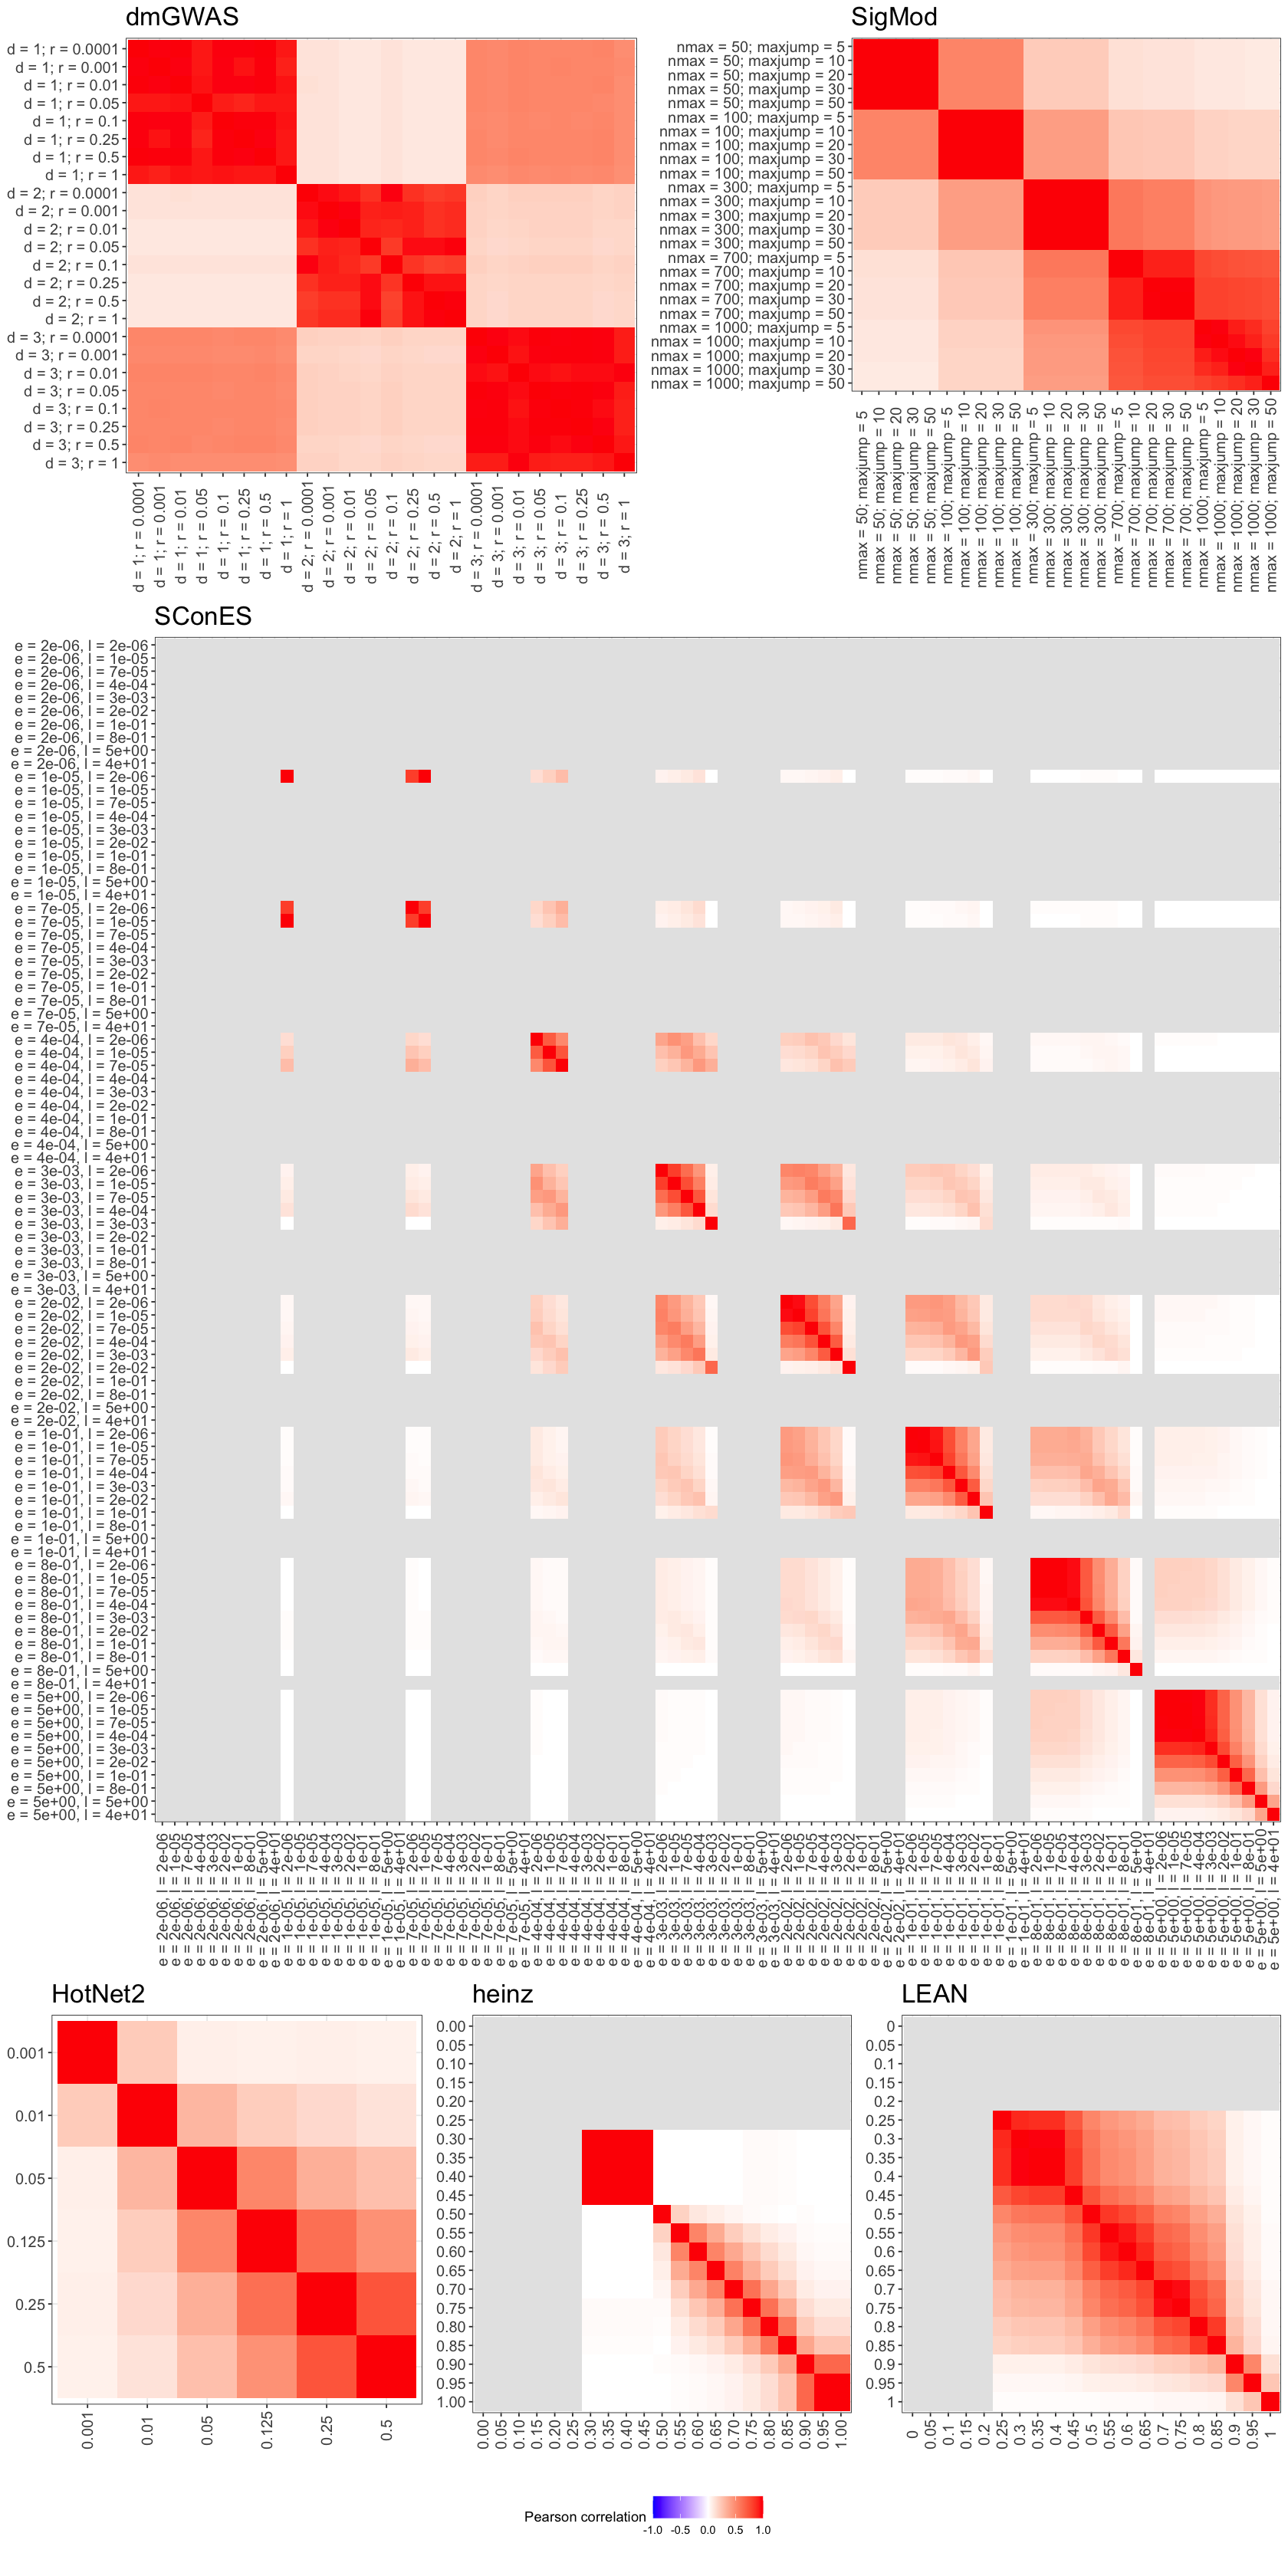

In [38]:
options(repr.plot.width=14, repr.plot.height=28)
sf8
ggsave('figures/sfigure_8.pdf', sf8, width=14, height=28, bg = "transparent")

# SF9: Biotypes

In [22]:
types <- c('tRNA' = 'Transfer RNA',
           'Mt-tRNA' = 'Mitochondrial transfer RNA',
           'rRNA' = 'Ribosomal RNA',
           'rRNA Pseudogene' = 'Ribosomal RNA Pseudogene',
           'scRNA' = 'Small cytoplasmic RNA',
           'snRNA' = 'Small nuclear RNA',
           'snoRNA' = 'Small nucleolar RNA',
           'miRNA' = 'MicroRNA precursors',
           'misc_RNA' = 'Other RNA',
           'lincRNA' = 'Long intergenic non-coding RNAs',
           'lncRNA' = 'Long non-coding RNAs',
           'vaultRNA' = 'Vault RNAs',
           'scaRNA' = 'Small Cajal body-specific RNA',
           'ribozyme' = 'Ribozyme',
           'TEC' = 'To be experimentally confirmed')

hgnc <- read_tsv(paste0(results,'preprocessing/non_alt_loci_set.txt'), 
                 col_types = cols(.default = "c")) %>%
    select(symbol, ensembl_gene_id)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = "c")) %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph
gene_types <- read_tsv(paste0(results,'bad_genes/gencode.v31.annotation.gff3'), comment = '#', 
                       col_names = FALSE, col_types = cols(.default = "c")) %>%
    filter(X3 == 'gene') %>%
    select(X9) %>%
    mutate(X9 = gsub('ID=', '', X9),
           X9 = gsub('\\.[0-9]+;gene_id.+gene_type=', ';', X9),
           X9 = gsub(';gene_name.+', '', X9)) %>%
    separate(X9, into = c('ensembl_gene_id','type'), sep = ';') %>%
    mutate(type = ifelse(type %in% names(types), types[type], type),
           type = gsub('TR', 'T-cell receptor', type),
           type = gsub('IG', 'Immunoglobulin', type)) %>%
    inner_join(hgnc, by = "ensembl_gene_id")

genes_icogs <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')$gene %>% unique
genes_hint <- as_tibble(ppi)$name

sf9 <- filter(gene_types, symbol %in% setdiff(genes_icogs, genes_hint)) %>%
    mutate(type = gsub('_', ' ', type),
           type = ifelse(grepl(' ', type), tools::toTitleCase(type), type)) %>%
    group_by(type) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(type = factor(type, levels = type)) %>%
    ggplot(aes(x = type, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene type', y = 'Counts') +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))

Warning message:
“Expected 2 pieces. Additional pieces discarded in 45 rows [60000, 60001, 60002, 60003, 60004, 60005, 60006, 60007, 60008, 60009, 60010, 60011, 60012, 60013, 60014, 60015, 60016, 60017, 60018, 60019, ...].”
`summarise()` ungrouping output (override with `.groups` argument)



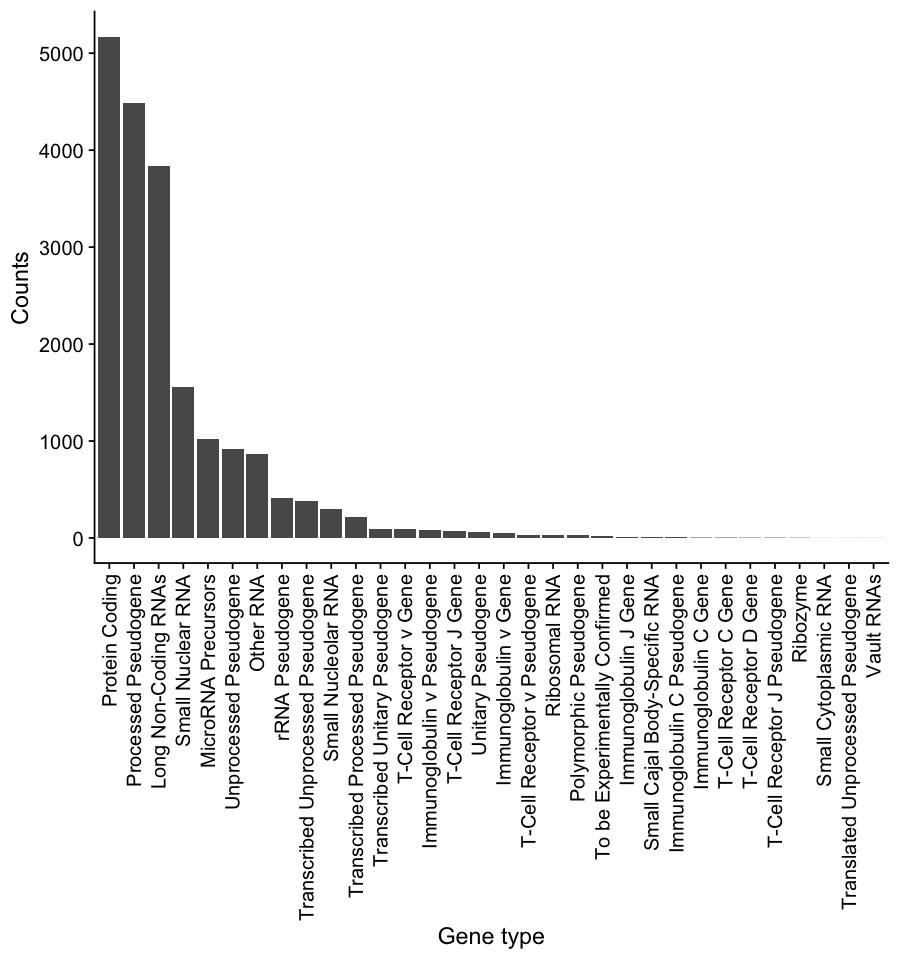

In [23]:
options(repr.plot.width=7.5, repr.plot.height=8)
sf9
ggsave('figures/sfigure_9.pdf', sf9, width=7, height=6, bg = "transparent")

# SF10: HT vs. (HT + LC)

In [24]:
labs <- c('all_snps' = 'All', 'chi^2~+~Bonferroni' = bquote(chi^2 ~ '+ Bonferroni'), 
          'consensus' = 'Consensus', 'dmgwas' = 'dmGWAS', 'heinz' = 'heinz', 
          'hotnet2' = 'HotNet2', 'lean' = 'LEAN', 'SConES~GI' = 'SConES GI', 
          'SConES~GM' = 'SConES GM', 'SConES~GS' = 'SConES GS', 'sigmod' = 'SigMod')

parse_deltatime <- function(column) {
    
    parse_subfield <- function (x) {
        if (grepl('ms', x)) {
            x <- gsub('ms', '', x) %>% as.numeric
            x <- x / 1000
        } else if (grepl('s', x)) {
            x <- gsub('s', '', x) %>% as.numeric
        } else if (grepl('m', x)) {
            x <- gsub('m', '', x) %>% as.numeric
            x <- x * 60
        } else if (grepl('h', x)) {
            x <- gsub('h', '', x) %>% as.numeric
            x <- x * 3600
        } else if (grepl('d', x)) {
            x <- gsub('d', '', x) %>% as.numeric
            x <- x * 3600 * 24
        } else {
            x <- NA
        }
        return(x)   
    }
    
    strsplit(column, ' ') %>% lapply(function(x) lapply(x, parse_subfield) %>% unlist) %>% lapply(sum) %>% unlist  
}

methods <- c('dmGWAS','heinz','HotNet2','LEAN','SigMod','SConES~GS','SConES~GM',
             'SConES~GI','Consensus','All','chi^2~+~Bonferroni')

pred_ht <- read_tsv(paste0(results,'benchmark/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones_gs', 'SConES~GS', method),
           method = ifelse(method == 'scones_gm', 'SConES~GM', method),
           method = ifelse(method == 'scones_gi', 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'all_snps', 'All', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method))
stab_ht <- read_tsv(paste0(results,'benchmark/stability.tsv'), col_types = 'cicd') %>%
    filter(method != 'all_snps') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones_gs', 'SConES~GS', method),
           method = ifelse(method == 'scones_gm', 'SConES~GM', method),
           method = ifelse(method == 'scones_gi', 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           method = factor(method, levels = rev(methods)))                                     
time_ht <- read_tsv(paste0(results,'benchmark/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES~GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES~GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           time_s = parse_deltatime(realtime),
           alg_time_s = parse_deltatime(realtime),
           tot_time_s = alg_time_s + mean(alg_time_s[method == 'vegas']),
           tot_time_s = ifelse(grepl('SConES', method), alg_time_s, tot_time_s),
           type = ifelse(grepl('SConES', method), 'SNP', 'Gene'),
           method = factor(method, levels = rev(methods))) %>%
    filter(!is.na(method)) %>%
    filter(!method %in% c('chi^2~+~Bonferroni','Consensus'))

pred_lc <- read_tsv(paste0(results,'lc_ht_network/prediction.tsv'), col_types = 'ciidd') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones_gs', 'SConES~GS', method),
           method = ifelse(method == 'scones_gm', 'SConES~GM', method),
           method = ifelse(method == 'scones_gi', 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method))
stab_lc <- read_tsv(paste0(results,'lc_ht_network/stability.tsv'), col_types = 'cicd') %>%
    filter(method != 'all_snps') %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones_gs', 'SConES~GS', method),
           method = ifelse(method == 'scones_gm', 'SConES~GM', method),
           method = ifelse(method == 'scones_gi', 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           method = factor(method, levels = rev(methods)))
time_lc <- read_tsv(paste0(results,'lc_ht_network/trace.txt'), col_types = 'iciccicccccccc') %>%
    separate(name, into = c('method','i'), sep = ' \\(') %>%
    filter(! method %in% c('lasso','make_splits','stability','all_snps',
                           'do_nothing','join_stability','join_analyses')) %>%
    mutate(method = ifelse(method == 'dmgwas', 'dmGWAS', method),
           method = ifelse(method == 'hotnet2', 'HotNet2', method),
           method = ifelse(method == 'scones' & grepl('gs', i), 'SConES~GS', method),
           method = ifelse(method == 'scones' & grepl('gm', i), 'SConES~GM', method),
           method = ifelse(method == 'scones' & grepl('gi', i), 'SConES~GI', method),
           method = ifelse(method == 'sigmod', 'SigMod', method),
           method = ifelse(method == 'lean', 'LEAN', method),
           method = ifelse(method == 'consensus', 'Consensus', method),
           method = ifelse(method == 'chi2', 'chi^2~+~Bonferroni', method),
           time_s = parse_deltatime(realtime),
           alg_time_s = parse_deltatime(realtime),
           tot_time_s = alg_time_s + mean(alg_time_s[method == 'vegas']),
           tot_time_s = ifelse(grepl('SConES', method), alg_time_s, tot_time_s),
           type = ifelse(grepl('SConES', method), 'SNP', 'Gene'),
           method = factor(method, levels = rev(methods))) %>%
    filter(!is.na(method)) %>%
    filter(!method %in% c('chi^2~+~Bonferroni','Consensus'))

Warning message:
“1 parsing failure.
row  col   expected actual                                file
 89 exit an integer      - '../../results/benchmark/trace.txt'
”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [128, 133].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [126, 133].”


In [25]:
sel_act <- inner_join(group_by(pred_lc, method) %>%
                           summarize(n_selected = mean(n_selected),
                                     n_active = mean(n_active_set)),
                       group_by(pred_ht, method) %>%
                           summarize(n_selected = mean(n_selected),
                                     n_active = mean(n_active_set)),
                       by = 'method', suffix = c('_lc','_ht')) %>%
    filter(! method %in% c('All', 'SConES~GS', 'SConES~GM')) %>%
    group_by(method) %>%
    filter(method != 'All') %>%
    summarize(delta_selected = n_selected_lc/n_selected_ht,
              delta_active = n_active_lc/n_active_ht) %>%
    ggplot(aes(x = delta_selected, y = delta_active, 
               label = method, color = method)) +
        geom_point(size = 3) +
        geom_hline(yintercept = 1, color = 'gray') +
        geom_vline(xintercept = 1, color = 'gray') +
        scale_color_manual(values = method_palette) +
        labs(x = 'Ratio selected', y = 'Ratio active') +
        theme(legend.position = 'none',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11))

sens_spec <- inner_join(group_by(pred_lc, method) %>%
                            summarize(sensitivity = mean(sensitivity),
                                      specificity = mean(specificity)),
                        group_by(pred_ht, method) %>%
                            summarize(sensitivity = mean(sensitivity),
                                      specificity = mean(specificity)),
                        by = 'method', suffix = c('_lc','_ht')) %>%
    filter(! method %in% c('All', 'SConES~GS', 'SConES~GM')) %>%
    group_by(method) %>%
    summarize(delta_sensitivity = sensitivity_ht - sensitivity_lc,
              delta_specificity = specificity_ht - specificity_lc) %>%
    ggplot(aes(x = delta_sensitivity, y = delta_specificity, 
               label = method, color = method)) +
        geom_point(size = 3) +
        geom_hline(yintercept = 0, color = 'gray') +
        geom_vline(xintercept = 0, color = 'gray') +
        scale_color_manual(values = method_palette, labels = labs) +
        labs(x = expression(paste(Delta, ' sensitivity')),
             y = expression(paste(Delta, ' specificity')),
             color = 'Method') +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(size = 9),
              axis.text.y = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              axis.title.y = element_text(size = 11))

jacc <- inner_join(group_by(stab_lc, method) %>%
                            summarize(pearson = mean(pearson)),
                   group_by(stab_ht, method) %>%
                            summarize(pearson = mean(pearson)),
                        by = 'method', suffix = c('_lc','_ht')) %>%
    filter(! method %in% c('All', 'SConES~GS', 'SConES~GM')) %>%
    group_by(method) %>%
    summarize(ratio_pearson = pearson_ht / pearson_lc) %>%
    ggplot(aes(x = ratio_pearson, y = method, color = method)) +
        geom_point(size = 3) +
        geom_vline(xintercept = 1, color = 'gray') +
        scale_y_discrete(labels = labs) +
        labs(x = 'Ratio correlation') +
        scale_color_manual(values = method_palette) +
        theme(axis.title.y = element_blank(),
              legend.position = 'none',
              axis.text.y = element_text(size = 9),
              axis.text.x = element_text(size = 9),
              axis.title.x = element_text(size = 11))

time <- inner_join(group_by(time_lc, method, type) %>%
                       summarize(alg_time_s = mean(alg_time_s),
                                 tot_time_s = mean(tot_time_s)),
                   group_by(time_ht, method, type) %>%
                       summarize(alg_time_s = mean(alg_time_s),
                                 tot_time_s = mean(tot_time_s)),
                   by = c('method','type'), suffix = c('_lc','_ht')) %>%
    group_by(method, type) %>%
    summarize(ratio_alg_time_s = alg_time_s_lc / alg_time_s_ht,
              ratio_tot_time_s = tot_time_s_lc / tot_time_s_ht) %>%
    select(method, ratio_alg_time_s, ratio_tot_time_s, type) %>%
    gather(time_type, ratio_time_s, -type, -method) %>%
    filter(!(method == 'SConES~GI' & time_type == 'ratio_alg_time_s')) %>%
    filter(! method %in% c('All', 'SConES~GS', 'SConES~GM')) %>%
    ggplot(aes(x = ratio_time_s, y = method, fill = method, size = time_type, shape = time_type)) +
        geom_vline(xintercept = 1, color = 'gray') +
        geom_point(color = 'black') +
        scale_y_discrete(labels = labs) +
        labs(x = 'Ratio time (s)') +
        scale_fill_manual(values = method_palette) +
        scale_shape_manual(values=c('ratio_alg_time_s' = 25, 'ratio_tot_time_s' = 21)) +
        scale_size_manual(values=c('ratio_alg_time_s' = 1.5, 'ratio_tot_time_s' = 3)) +
        theme(axis.title.y = element_blank(),
              legend.position = 'none',
              axis.text.y = element_text(size = 9),
              axis.text.x = element_text(size = 9),
              axis.title.x = element_text(size = 11),
              strip.text = element_text(size = 10),
              strip.background = element_rect(fill="gray90")) +
        facet_grid(type ~ ., scales = 'free', space = 'free')

sf10 <- plot_grid(
        plot_grid(plot_grid(sel_act, sens_spec + theme(legend.position = 'none'), 
                            ncol = 2, labels = c('A','B')),
                  get_legend(sens_spec), nrow = 2, rel_heights = c(1,.2)),
        plot_grid(jacc, time, labels = c('C','D')),
        nrow = 2, rel_heights = c(1.25, 1))

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)

`summarise()` regrouping output by 'method' (override with `.groups` argument)

Warning message:
“Removed 1 rows containing missing values (geom_point).”


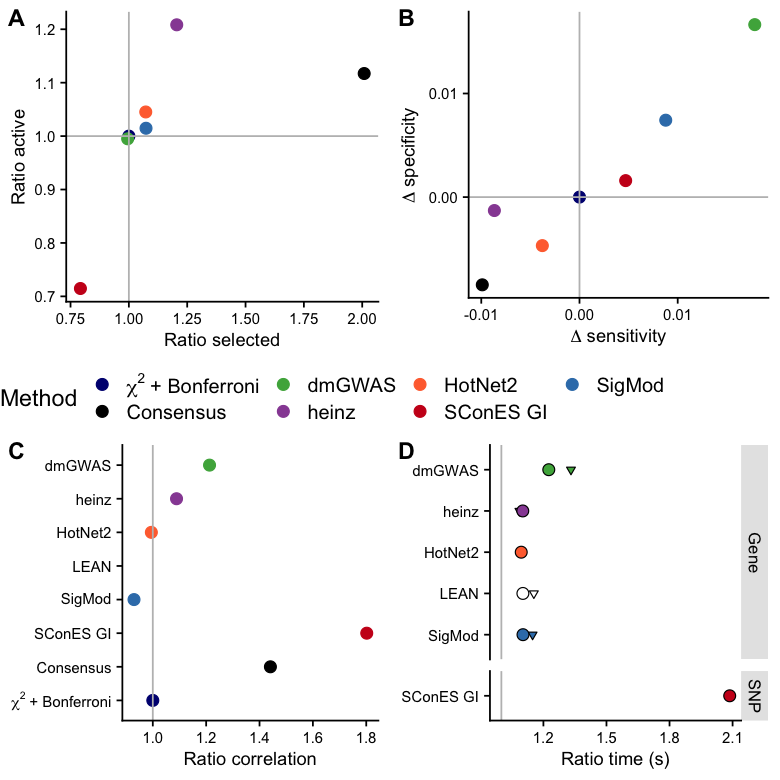

In [26]:
options(repr.plot.width=6.5, repr.plot.height=6.5)
sf10
ggsave('figures/sfigure_10.pdf', sf10, width=6.5, height=8, bg = "transparent")

# SF10: SConES GS and GM comparisons

In [27]:
method_palette <- c('dmGWAS' = '#4daf4a', 'heinz' = '#984ea3',
                    'HotNet2' = '#ff7f00', 'SConES~GS' = '#fb6a4a',
                    'SConES~GM' = '#cb181d', 'SConES~GI' = '#67000d',
                    'SigMod' = '#377eb8', 'All' = 'black', 'Consensus' = 'black', 
                    'chi^2~+~Bonferroni' = '#000080')

In [28]:
gwas <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdccccddd') %>%
    rename(chr = CHR, snp = SNP) %>%
    inner_join(map, by = c('chr', 'snp')) %>%
    mutate(selected = ifelse(P < (0.05/n()), 'Yes', 'No')) %>%
    arrange(selected)

don <- gwas %>% 

  # Compute chromosome size
  group_by(chr) %>% 
  summarise(chr_len=max(pos)) %>% 

  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%

  # Add this info to the initial dataset
  left_join(gwas, ., by='chr') %>%

  # Add a cumulative position of each SNP
  arrange(chr, pos) %>%
  mutate( BPcum=pos+tot) %>%
  left_join(arrange(snp2gene, gene) %>% group_by(snp) %>% summarize(gene = head(gene, 1)), by = 'snp')

bf_threshold <- .05 / (nrow(gwas))
y_lim <- max(-log10(don$P), na.rm = TRUE) + 1
axisdf <- don %>% 
    group_by(chr) %>% 
    summarize(center=( max(BPcum) + min(BPcum) ) / 2 ) %>%
    mutate(chr_fix = ifelse(chr %in% c(14,16,18,20,22), '', chr))

snp_manhattan <- ggplot(don, aes(x=BPcum, y=-log10(P))) +

    # Show all points
    geom_point( aes(color=as.factor(chr)), alpha=0.8, size=1.3) +
    scale_color_manual(values = rep(c("#cbf1f5", "#a6e3e9"), 22 )) +

    # Add Bonferroni line
    geom_hline(yintercept = -log10(bf_threshold), color = '#e84545') +

    # custom X axis:
    scale_x_continuous( label = axisdf$chr_fix, breaks= axisdf$center ) +
    scale_y_continuous(expand = c(0, 0), limits = c(0, y_lim)) +  # remove space between plot area and x axis

    # Custom the theme:
    theme_bw() +
    theme( 
      legend.position="none",
      panel.border = element_blank(),
      axis.title = element_text(size = 10),
      axis.text = element_text(size = 8),
      strip.text.y = element_text(size = .5),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    ) +
    labs(x = 'Chromosome', y = bquote('-log' [10] ~'(SNP P-value)')) +
    theme_transparent

scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
gs_mh <- snp_manhattan + geom_point(data = filter(don, snp %in% scones_gs), aes(x=BPcum, y=-log10(P)), color = '#2b2e4a')

scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
gm_mh <- snp_manhattan + geom_point(data = filter(don, snp %in% scones_gm), aes(x=BPcum, y=-log10(P)), color = '#2b2e4a')

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [29]:
snps <- inner_join(
           read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')

plot_selected_snps <- function(snps, selected, title) {
    
    p_bonf_snps = .05 / nrow(snps)
    
    snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No'),
           selected = ifelse(SNP %in% selected, 'Selected', 'Unselected'),
           selected = factor(selected, levels = c('Unselected','Selected'))) %>%
    select(selected, sign_bcac) %>%
    gather(where, sign, -selected) %>%
    ggplot(aes(x = sign, fill = selected)) +
        geom_bar(position = 'fill') +
        labs(fill = '', y = 'Fraction', x = 'BCAC significant SNP', title = title) +
        theme_bw() +
        scale_fill_manual(values = palette_yn) +
        theme(legend.position = 'none',
              axis.text = element_text(size = 8),
              axis.title = element_text(size = 10),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 10),
              strip.text = element_text(size = 10)) +
        theme_transparent
    
}

gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gs_bcac <- plot_selected_snps(snps, gs, '')

gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm_bcac <- plot_selected_snps(snps, gm, '')

In [30]:
snps <- inner_join(
           read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_bcac = P),
           read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                    col_types = 'icdcddcddd') %>%
               select(SNP, P) %>%
               rename(p_genesis = P),
           by = 'SNP')

plot_selected_snps <- function(snps, selected, title) {
    
    p_bonf_snps = .05 / nrow(snps)
    
    snps %>%
    mutate(sign_genesis = ifelse(p_genesis < p_bonf_snps, 'Yes', 'No'),
           sign_bcac = ifelse(p_bcac < p_bonf_snps, 'Yes', 'No'),
           selected = ifelse(SNP %in% selected, 'Selected', 'Unselected'),
           selected = factor(selected, levels = c('Unselected','Selected'))) %>%
    select(selected, sign_genesis) %>%
    gather(where, sign, -selected) %>%
    ggplot(aes(x = sign, fill = selected)) +
        geom_bar(position = 'fill') +
        labs(fill = '', y = 'Fraction', x = 'GENESIS significant SNP', title = title) +
        theme_bw() +
        scale_fill_manual(values = palette_yn) +
        theme(legend.position = 'none',
              axis.text = element_text(size = 8),
              axis.title = element_text(size = 10),
              legend.text = element_text(size = 9),
              legend.title = element_text(size = 10),
              strip.text = element_text(size = 10)) +
        theme_transparent
    
}

gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gs_genesis <- plot_selected_snps(snps, gs, '')

gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm_genesis <- plot_selected_snps(snps, gm, '')

In [31]:
# GENE comparison
# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = 'c')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)

genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)
genes <- read_tsv(paste0(results,'bcac/scored_genes.vegas.join_genesis.txt'), 
                  col_types = 'iciddddddcddddddcdll') %>%
    filter(Gene %in% genes_in_ppi)

plot_selected_genes <- function(genes, selected, method) {
    
    known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                                 col_types = 'ccciccciddddcddddd')$Gene
    
    genes %>%
        mutate(bc_gene = ifelse(Gene %in% known_brca_genes, 'Yes', 'No'),
               selected = ifelse(Gene %in% selected, 'Selected', 'Unselected'),
               selected = factor(selected, levels = c('Unselected','Selected'))) %>%
        select(selected, bc_gene) %>%
        ggplot(aes(x = bc_gene, fill = selected)) +
            geom_bar(position = 'fill') +
            labs(y = 'Fraction', x = 'Familial BC gene',  
                 fill = 'Selected gene', title = method) +
            theme_bw() +
            scale_fill_manual(values = palette_yn) +
            theme(legend.position = 'none',
                  axis.text = element_text(size = 8),
                  axis.title = element_text(size = 10),
                  strip.text = element_text(size = 10)) +
            theme_transparent
    
}

scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene
gs_bc <- plot_selected_genes(genes, scones_gs, '')

scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene
gm_bc <- plot_selected_genes(genes, scones_gm, '')

legend <- cowplot::get_legend(gm_bc + theme(legend.position="bottom"))

In [32]:
# GENE comparison
# use only genes that can be found in the PPIN
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), 
                col_types = cols(.default = 'c')) %>%
    rename(gene_a = `Official Symbol Interactor A`, 
           gene_b = `Official Symbol Interactor B`)

genes_in_ppi <- c(ppi$gene_a, ppi$gene_b)
genes_in_genesis <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                             col_types = 'iciddddddcd') %>%
    .$Gene
genes <- read_tsv(paste0(results,'bcac/scored_genes.vegas.join_genesis.txt'), 
                  col_types = 'iciddddddcddddddcdll') %>%
    filter(Gene %in% genes_in_ppi) %>%
    rename(P = `Top-0.1-pvalue_bcac`,
           marker = Gene) %>%
    select(marker, P)

# scones comparison
snps_genesis <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd') %>%
    .$SNP
snps <- read_tsv(paste0(results,'bcac/oncoarray_bcac_public_release_oct17.genesis.assoc'), 
                 col_types = 'icdcddcddd') %>%
    filter(SNP %in% snps_genesis) %>%
    rename(marker = SNP) %>%
    select(marker, P)

get_precision_recall <- function(genes, selected, method, bonf) {
    
    genes %>%
        mutate(sign = P < bonf,
               selected = marker %in% selected) %>%
        summarize(precision = sum(selected & sign)/sum(selected),
                  recall = sum(selected & sign)/sum(sign)) %>%
        mutate(method = method)
    
}

genesis_sign <- read_tsv(paste0(results,'conventional_gwas/univariate_models.no_covars.tsv'), 
                 col_types = 'icdcddcddd')  %>%
    filter(P < (.05/n()) ) %>%
    .$SNP
consensus <- read_tsv(paste0(results,'consensus/consensus.tsv'), col_types = 'cdidllllllli')$gene
lean <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd') %>%
    filter(PLEAN < 0.05) %>%
    .$Gene
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene
hotnet2 <- read_tsv(paste0(results,'hotnet2/selected_genes.hotnet2.tsv'), col_types = 'cc', 
         comment = '#', col_names = F) %>%
    select(X1) %>%
    separate_rows(X1, sep = ' ') %>%
    .$X1
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene
gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp
gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = "ciiiccdli") %>%
    filter(selected) %>%
    .$snp

gs_gm_bcac <- bind_rows(get_precision_recall(snps, genesis_sign, 'chi^2~+~Bonferroni', .05 / nrow(snps)),
          get_precision_recall(genes, consensus, 'Consensus', .05 / nrow(genes)),
          get_precision_recall(genes, lean, 'LEAN', .05 / nrow(genes)),
          get_precision_recall(genes, sigmod, 'SigMod', .05 / nrow(genes)),
          get_precision_recall(genes, dmgwas, 'dmGWAS', .05 / nrow(genes)),
          get_precision_recall(genes, hotnet2, 'HotNet2', .05 / nrow(genes)),
          get_precision_recall(snps, gs, 'SConES~GS', .05 / nrow(snps)),
          get_precision_recall(snps, gm, 'SConES~GM', .05 / nrow(snps)),
          get_precision_recall(snps, gi, 'SConES~GI', .05 / nrow(snps))) %>%
    ggplot(aes(recall, precision, color = method, label = method)) +
        geom_abline(slope = 1, color = 'gray80') +
        geom_point() +
        geom_text_repel(parse = T) +
        labs(x = 'Recall', y = 'Precision') + 
        scale_x_continuous(labels = scales::percent) +
        scale_y_continuous(labels = scales::percent) +
        scale_color_manual(values = method_palette) +
        theme(legend.position = 'none',
              text = element_text(size = 10),
              axis.title = element_text(size = 15))

In [33]:
plot_network <- function(net, selected_nodes) {
    
    graph <- activate(net, nodes) %>%
        filter(name %in% selected_nodes)
    class(graph) <- c('igraph','tbl_graph')
    
    ggnetwork(graph) %>%
        mutate(name = as.character(name)) %>%
        ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
            geom_edges(color = 'gray20') +
            geom_nodes(color = 'gray20') +
            theme_blank() + theme_transparent + 
            theme(title = element_text(hjust = 1, face = 'bold'))
}

load(paste0(results,'scones/gs_network.betweenness.RData'))
scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
scones_gs_plt <- plot_network(gs_net, scones_gs)

load(paste0(results,'scones/gm_network.betweenness.RData'))
scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    .$snp
scones_gm_plt <- plot_network(gm_net, scones_gm)

In [34]:
sf11 <- plot_grid(plot_grid(plot_grid(gs_mh, gm_mh, labels = c('SConES GS','SConES GM')),
                            gs_gm_bcac, labels = c('A','B'), rel_widths = c(2,1), label_size = 20),
                  plot_grid(scones_gs_plt, scones_gm_plt, labels = c('SConES GS','SConES GM')),
                  labels = c('','C'), nrow = 2, label_size = 20)

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”


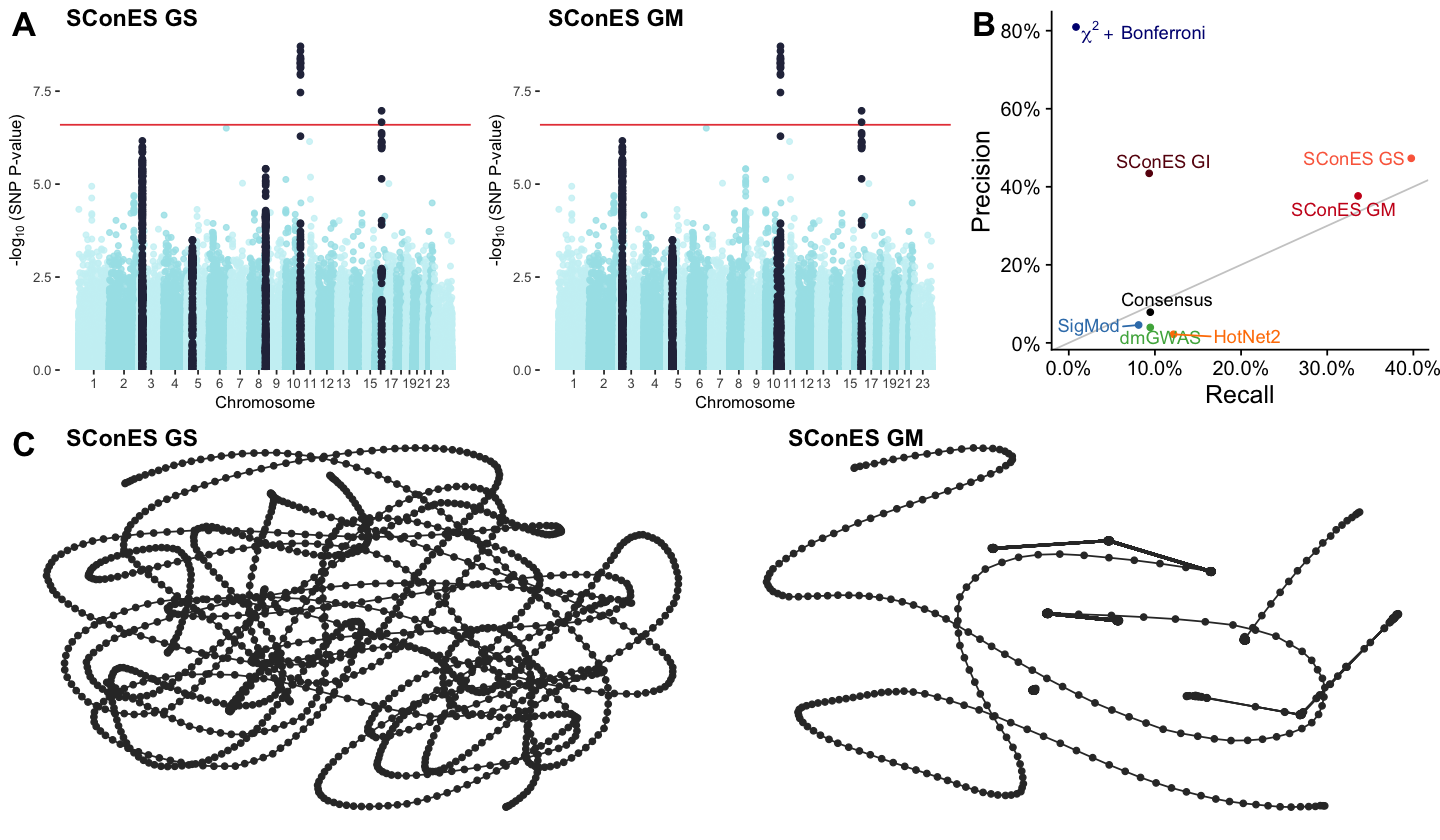

In [35]:
options(repr.plot.width=12, repr.plot.height=7)
sf11
ggsave('figures/sfigure_11.pdf', sf10, width=12, height=7, bg = "transparent")
ggsave('figures/sfigure_11.png', sf10, width=12, height=7, bg = "transparent")